<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S12/S11-TB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S12/')
%reload_ext autoreload
%autoreload 2

import zipfile

path_to_zip_file = "/content/gdrive/My Drive/Colab Notebooks/EVA4/S12/data/tiny-imagenet-200.zip"
directory_to_extract_to = '/content/gdrive/My Drive/Colab Notebooks/EVA4/S12/data/tiny-imagenet-200'
#print("Extracting zip file: %s" % path_to_zip_file)
#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#  zip_ref.extractall(directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

from config import ModelConfig
from models.resnet import ResNet18
from train import train
from results import plot_images, plot_graph
from utilities import *
from data.data_engine import DataEngine
from gradcam.visualize import VisualizeCam
from lr_test.lr_range_test import LRRangeFinder
from lr_test.lr_cycle_plot import LRCyclePlot

#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Extracted at: /content/gdrive/My Drive/Colab Notebooks/EVA4/S12/data/tiny-imagenet-200
Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'test_data_path': '/content/gdrive/My Drive/Colab '
                    'Notebooks/EVA4/S12/data/tiny-imagenet-200/test',
  'train_data_path': '/content/gdrive/My Drive/Colab '
                     'Notebooks/EVA4/S12/data/tiny-imagenet-200/train'}

CUDA Available


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



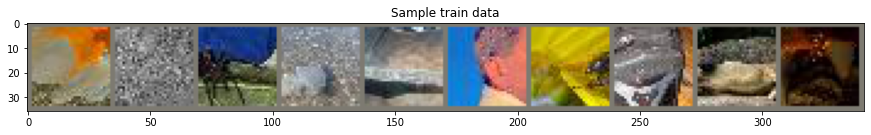

In [ ]:
data = DataEngine(args)
data.show_samples()

In [ ]:
device = which_device()
model = ResNet18(num_classes=200).to(device)
show_model_summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc >= 90.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

In [ ]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(data.train_loader),
                       epochs=epochs, div_factor=10, final_div_factor=10,
                       pct_start=10/epochs)

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, False)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/119 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.002000)


L2_loss=464.325 Loss=5.48720 Batch_id=118 Accuracy=17.25: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 5.1326, Accuracy: 117/10000 (1.17%)

EPOCH: 2 (LR: 0.002441)


L2_loss=463.440 Loss=5.50964 Batch_id=118 Accuracy=21.28: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 6.2781, Accuracy: 153/10000 (1.53%)

EPOCH: 3 (LR: 0.003722)


L2_loss=462.327 Loss=5.55371 Batch_id=118 Accuracy=24.05: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 5.8560, Accuracy: 140/10000 (1.40%)

EPOCH: 4 (LR: 0.005716)


L2_loss=460.987 Loss=5.35905 Batch_id=118 Accuracy=26.46: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 5.5183, Accuracy: 185/10000 (1.85%)

EPOCH: 5 (LR: 0.008228)


L2_loss=459.505 Loss=4.90736 Batch_id=118 Accuracy=28.87: 100%|██████████| 119/119 [00:47<00:00,  2.48it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 6.4981, Accuracy: 138/10000 (1.38%)

EPOCH: 6 (LR: 0.011012)


L2_loss=457.906 Loss=4.92737 Batch_id=118 Accuracy=30.83: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 6.4203, Accuracy: 115/10000 (1.15%)

EPOCH: 7 (LR: 0.013795)


L2_loss=456.189 Loss=4.93168 Batch_id=118 Accuracy=33.36: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.0796, Accuracy: 43/10000 (0.43%)

EPOCH: 8 (LR: 0.016304)


L2_loss=454.439 Loss=4.55974 Batch_id=118 Accuracy=35.04: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 6.6298, Accuracy: 31/10000 (0.31%)

EPOCH: 9 (LR: 0.018292)


L2_loss=452.670 Loss=4.65380 Batch_id=118 Accuracy=36.39: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 6.2810, Accuracy: 78/10000 (0.78%)

EPOCH: 10 (LR: 0.019566)


L2_loss=450.852 Loss=4.90898 Batch_id=118 Accuracy=38.04: 100%|██████████| 119/119 [00:47<00:00,  2.48it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 6.4512, Accuracy: 104/10000 (1.04%)

EPOCH: 11 (LR: 0.020000)


L2_loss=448.979 Loss=4.25881 Batch_id=118 Accuracy=39.91: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.0970, Accuracy: 66/10000 (0.66%)

EPOCH: 12 (LR: 0.019876)


L2_loss=447.162 Loss=4.32934 Batch_id=118 Accuracy=40.91: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.2791, Accuracy: 10/10000 (0.10%)

EPOCH: 13 (LR: 0.019511)


L2_loss=445.337 Loss=4.31682 Batch_id=118 Accuracy=41.81: 100%|██████████| 119/119 [00:49<00:00,  2.42it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.2374, Accuracy: 86/10000 (0.86%)

EPOCH: 14 (LR: 0.018915)


L2_loss=443.529 Loss=4.42703 Batch_id=118 Accuracy=43.50: 100%|██████████| 119/119 [00:49<00:00,  2.42it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.2743, Accuracy: 72/10000 (0.72%)

EPOCH: 15 (LR: 0.018102)


L2_loss=441.777 Loss=4.38379 Batch_id=118 Accuracy=44.02: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 6.8317, Accuracy: 80/10000 (0.80%)

EPOCH: 16 (LR: 0.017091)


L2_loss=440.047 Loss=4.42970 Batch_id=118 Accuracy=45.80: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.5731, Accuracy: 44/10000 (0.44%)

EPOCH: 17 (LR: 0.015908)


L2_loss=438.367 Loss=4.17652 Batch_id=118 Accuracy=46.26: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3030, Accuracy: 16/10000 (0.16%)

EPOCH: 18 (LR: 0.014583)


L2_loss=436.706 Loss=4.25344 Batch_id=118 Accuracy=47.71: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.3304, Accuracy: 105/10000 (1.05%)

EPOCH: 19 (LR: 0.013147)


L2_loss=435.105 Loss=4.22951 Batch_id=118 Accuracy=48.62: 100%|██████████| 119/119 [00:48<00:00,  2.43it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 6.3747, Accuracy: 143/10000 (1.43%)

EPOCH: 20 (LR: 0.011636)


L2_loss=433.629 Loss=3.96661 Batch_id=118 Accuracy=49.47: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.8812, Accuracy: 55/10000 (0.55%)

EPOCH: 21 (LR: 0.010087)


L2_loss=432.230 Loss=3.93992 Batch_id=118 Accuracy=50.77: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.0129, Accuracy: 41/10000 (0.41%)

EPOCH: 22 (LR: 0.008538)


L2_loss=430.912 Loss=3.98858 Batch_id=118 Accuracy=51.53: 100%|██████████| 119/119 [00:49<00:00,  2.43it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.0151, Accuracy: 48/10000 (0.48%)

EPOCH: 23 (LR: 0.007028)


L2_loss=429.712 Loss=3.97122 Batch_id=118 Accuracy=53.16: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.5532, Accuracy: 58/10000 (0.58%)

EPOCH: 24 (LR: 0.005594)


L2_loss=428.646 Loss=3.81313 Batch_id=118 Accuracy=54.55: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.6860, Accuracy: 45/10000 (0.45%)

EPOCH: 25 (LR: 0.004270)


L2_loss=427.735 Loss=3.75944 Batch_id=118 Accuracy=56.38: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.7912, Accuracy: 82/10000 (0.82%)

EPOCH: 26 (LR: 0.003090)


L2_loss=427.006 Loss=3.50915 Batch_id=118 Accuracy=57.49: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.0164, Accuracy: 72/10000 (0.72%)

EPOCH: 27 (LR: 0.002083)


L2_loss=426.462 Loss=3.68337 Batch_id=118 Accuracy=59.04: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.9050, Accuracy: 64/10000 (0.64%)

EPOCH: 28 (LR: 0.001273)


L2_loss=426.105 Loss=3.36072 Batch_id=118 Accuracy=60.64: 100%|██████████| 119/119 [00:49<00:00,  2.39it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.1236, Accuracy: 57/10000 (0.57%)

EPOCH: 29 (LR: 0.000681)


L2_loss=425.907 Loss=3.62670 Batch_id=118 Accuracy=61.46: 100%|██████████| 119/119 [00:50<00:00,  2.36it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.9676, Accuracy: 70/10000 (0.70%)

EPOCH: 30 (LR: 0.000320)


L2_loss=425.803 Loss=3.53174 Batch_id=118 Accuracy=62.45: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


Test set: Average loss: 7.8304, Accuracy: 66/10000 (0.66%)



  0%|          | 0/119 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.002000)


L2_loss=425.229 Loss=3.52338 Batch_id=118 Accuracy=60.04: 100%|██████████| 119/119 [00:50<00:00,  2.35it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.0025, Accuracy: 72/10000 (0.72%)

EPOCH: 2 (LR: 0.002441)


L2_loss=424.385 Loss=3.97502 Batch_id=118 Accuracy=57.77: 100%|██████████| 119/119 [00:51<00:00,  2.32it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.7619, Accuracy: 95/10000 (0.95%)

EPOCH: 3 (LR: 0.003722)


L2_loss=423.384 Loss=3.84489 Batch_id=118 Accuracy=56.24: 100%|██████████| 119/119 [00:51<00:00,  2.33it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.4436, Accuracy: 46/10000 (0.46%)

EPOCH: 4 (LR: 0.005716)


L2_loss=422.299 Loss=3.76519 Batch_id=118 Accuracy=54.96: 100%|██████████| 119/119 [00:51<00:00,  2.31it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.1248, Accuracy: 92/10000 (0.92%)

EPOCH: 5 (LR: 0.008228)


L2_loss=421.144 Loss=3.77816 Batch_id=118 Accuracy=53.47: 100%|██████████| 119/119 [00:50<00:00,  2.37it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.2345, Accuracy: 111/10000 (1.11%)

EPOCH: 6 (LR: 0.011012)


L2_loss=419.875 Loss=4.00340 Batch_id=118 Accuracy=53.57: 100%|██████████| 119/119 [00:50<00:00,  2.38it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.6002, Accuracy: 150/10000 (1.50%)

EPOCH: 7 (LR: 0.013795)


L2_loss=418.570 Loss=3.72366 Batch_id=118 Accuracy=53.27: 100%|██████████| 119/119 [00:50<00:00,  2.38it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.1791, Accuracy: 45/10000 (0.45%)

EPOCH: 8 (LR: 0.016304)


L2_loss=417.256 Loss=3.64922 Batch_id=118 Accuracy=53.75: 100%|██████████| 119/119 [00:49<00:00,  2.40it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 9.7757, Accuracy: 27/10000 (0.27%)

EPOCH: 9 (LR: 0.018292)


L2_loss=415.856 Loss=4.05114 Batch_id=118 Accuracy=53.73: 100%|██████████| 119/119 [00:49<00:00,  2.41it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.8432, Accuracy: 53/10000 (0.53%)

EPOCH: 10 (LR: 0.019566)


L2_loss=414.430 Loss=3.77804 Batch_id=118 Accuracy=54.52: 100%|██████████| 119/119 [00:49<00:00,  2.43it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.1826, Accuracy: 148/10000 (1.48%)

EPOCH: 11 (LR: 0.020000)


L2_loss=413.036 Loss=4.00310 Batch_id=118 Accuracy=55.13: 100%|██████████| 119/119 [00:49<00:00,  2.41it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.6602, Accuracy: 94/10000 (0.94%)

EPOCH: 12 (LR: 0.019876)


L2_loss=411.637 Loss=3.61993 Batch_id=118 Accuracy=55.90: 100%|██████████| 119/119 [00:50<00:00,  2.38it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.5127, Accuracy: 47/10000 (0.47%)

EPOCH: 13 (LR: 0.019511)


L2_loss=410.186 Loss=3.64796 Batch_id=118 Accuracy=56.49: 100%|██████████| 119/119 [00:49<00:00,  2.43it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.6645, Accuracy: 171/10000 (1.71%)

EPOCH: 14 (LR: 0.018915)


L2_loss=408.783 Loss=3.61617 Batch_id=118 Accuracy=56.90: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.2427, Accuracy: 70/10000 (0.70%)

EPOCH: 15 (LR: 0.018102)


L2_loss=407.303 Loss=3.78381 Batch_id=118 Accuracy=57.77: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.4595, Accuracy: 56/10000 (0.56%)

EPOCH: 16 (LR: 0.017091)


L2_loss=405.928 Loss=3.47766 Batch_id=118 Accuracy=58.10: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3751, Accuracy: 25/10000 (0.25%)

EPOCH: 17 (LR: 0.015908)


L2_loss=404.511 Loss=3.73741 Batch_id=118 Accuracy=59.29: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.8259, Accuracy: 83/10000 (0.83%)

EPOCH: 18 (LR: 0.014583)


L2_loss=403.134 Loss=3.45057 Batch_id=118 Accuracy=59.52: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.9342, Accuracy: 30/10000 (0.30%)

EPOCH: 19 (LR: 0.013147)


L2_loss=401.778 Loss=3.61210 Batch_id=118 Accuracy=60.30: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.7820, Accuracy: 64/10000 (0.64%)

EPOCH: 20 (LR: 0.011636)


L2_loss=400.478 Loss=3.21488 Batch_id=118 Accuracy=61.81: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.6733, Accuracy: 71/10000 (0.71%)

EPOCH: 21 (LR: 0.010087)


L2_loss=399.251 Loss=3.42745 Batch_id=118 Accuracy=62.52: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3035, Accuracy: 60/10000 (0.60%)

EPOCH: 22 (LR: 0.008538)


L2_loss=398.088 Loss=3.33350 Batch_id=118 Accuracy=63.73: 100%|██████████| 119/119 [00:48<00:00,  2.43it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.5374, Accuracy: 40/10000 (0.40%)

EPOCH: 23 (LR: 0.007028)


L2_loss=396.996 Loss=3.49519 Batch_id=118 Accuracy=65.28: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.7209, Accuracy: 54/10000 (0.54%)

EPOCH: 24 (LR: 0.005594)


L2_loss=396.012 Loss=3.50373 Batch_id=118 Accuracy=66.66: 100%|██████████| 119/119 [00:49<00:00,  2.41it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.7147, Accuracy: 41/10000 (0.41%)

EPOCH: 25 (LR: 0.004270)


L2_loss=395.165 Loss=3.17056 Batch_id=118 Accuracy=68.39: 100%|██████████| 119/119 [00:47<00:00,  2.48it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 7.4882, Accuracy: 145/10000 (1.45%)

EPOCH: 26 (LR: 0.003090)


L2_loss=394.455 Loss=2.99155 Batch_id=118 Accuracy=70.07: 100%|██████████| 119/119 [00:49<00:00,  2.43it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.2910, Accuracy: 62/10000 (0.62%)

EPOCH: 27 (LR: 0.002083)


L2_loss=393.927 Loss=2.82409 Batch_id=118 Accuracy=71.64: 100%|██████████| 119/119 [00:50<00:00,  2.36it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.6059, Accuracy: 49/10000 (0.49%)

EPOCH: 28 (LR: 0.001273)


L2_loss=393.578 Loss=2.72700 Batch_id=118 Accuracy=73.22: 100%|██████████| 119/119 [00:49<00:00,  2.40it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.1349, Accuracy: 81/10000 (0.81%)

EPOCH: 29 (LR: 0.000681)


L2_loss=393.376 Loss=2.88908 Batch_id=118 Accuracy=74.60: 100%|██████████| 119/119 [00:49<00:00,  2.39it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3419, Accuracy: 68/10000 (0.68%)

EPOCH: 30 (LR: 0.000320)


L2_loss=393.270 Loss=2.81537 Batch_id=118 Accuracy=75.19: 100%|██████████| 119/119 [00:49<00:00,  2.42it/s]


Test set: Average loss: 8.2414, Accuracy: 73/10000 (0.73%)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1,
                              verbose=True, min_lr=1e-5)

misclassified_imgs, correct_imgs = [], []
epochs = 10
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1+30} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==epochs-1)
      scheduler.step(test_losses[-1])

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/119 [00:00<?, ?it/s]

EPOCH: 31 (LR: 0.000500)


L2_loss=393.176 Loss=2.82589 Batch_id=118 Accuracy=75.22: 100%|██████████| 119/119 [00:48<00:00,  2.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.2369, Accuracy: 74/10000 (0.74%)

EPOCH: 32 (LR: 0.000500)


L2_loss=393.077 Loss=2.85843 Batch_id=118 Accuracy=75.62: 100%|██████████| 119/119 [00:50<00:00,  2.37it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.1421, Accuracy: 76/10000 (0.76%)

EPOCH: 33 (LR: 0.000500)


L2_loss=392.976 Loss=2.95894 Batch_id=118 Accuracy=75.33: 100%|██████████| 119/119 [00:50<00:00,  2.36it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.2264, Accuracy: 71/10000 (0.71%)

EPOCH: 34 (LR: 0.000500)


L2_loss=392.876 Loss=2.91197 Batch_id=118 Accuracy=75.54: 100%|██████████| 119/119 [00:48<00:00,  2.45it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3542, Accuracy: 69/10000 (0.69%)

Epoch     4: reducing learning rate of group 0 to 2.5000e-04.
EPOCH: 35 (LR: 0.000250)


L2_loss=392.819 Loss=2.87955 Batch_id=118 Accuracy=75.82: 100%|██████████| 119/119 [00:48<00:00,  2.47it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.2578, Accuracy: 75/10000 (0.75%)

EPOCH: 36 (LR: 0.000250)


L2_loss=392.768 Loss=2.75024 Batch_id=118 Accuracy=76.37: 100%|██████████| 119/119 [00:47<00:00,  2.49it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3736, Accuracy: 70/10000 (0.70%)

Epoch     6: reducing learning rate of group 0 to 1.2500e-04.
EPOCH: 37 (LR: 0.000125)


L2_loss=392.740 Loss=2.96396 Batch_id=118 Accuracy=76.17: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3674, Accuracy: 71/10000 (0.71%)

EPOCH: 38 (LR: 0.000125)


L2_loss=392.714 Loss=2.70320 Batch_id=118 Accuracy=76.22: 100%|██████████| 119/119 [00:47<00:00,  2.53it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3969, Accuracy: 69/10000 (0.69%)

Epoch     8: reducing learning rate of group 0 to 6.2500e-05.
EPOCH: 39 (LR: 0.000063)


L2_loss=392.699 Loss=2.85798 Batch_id=118 Accuracy=76.37: 100%|██████████| 119/119 [00:48<00:00,  2.44it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Test set: Average loss: 8.3978, Accuracy: 71/10000 (0.71%)

EPOCH: 40 (LR: 0.000063)


L2_loss=392.686 Loss=2.65487 Batch_id=118 Accuracy=76.09: 100%|██████████| 119/119 [00:47<00:00,  2.50it/s]


Test set: Average loss: 8.3767, Accuracy: 71/10000 (0.71%)

Epoch    10: reducing learning rate of group 0 to 3.1250e-05.


In [ ]:
print('Device set to ', device)

Device set to  cuda


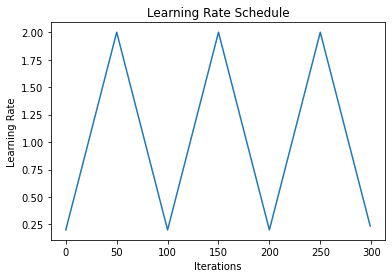

<Figure size 432x288 with 0 Axes>

In [ ]:
lrplt = LRCyclePlot({})
lrplt("lr_cycle_plot_test.png")

Let us show some of the training images, for fun.



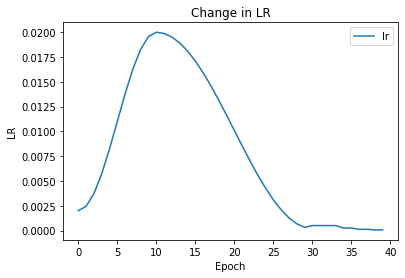

In [ ]:
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

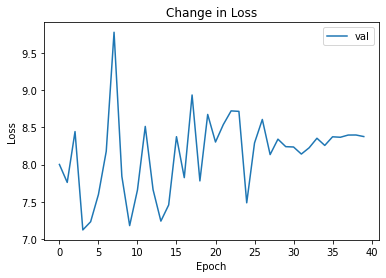

In [ ]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

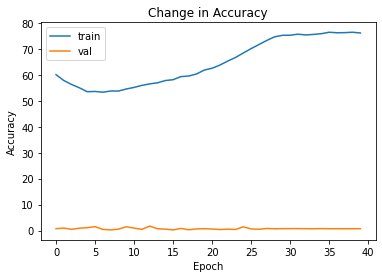

In [ ]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

In [ ]:

target_layers = ["layer1", "layer2", "layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

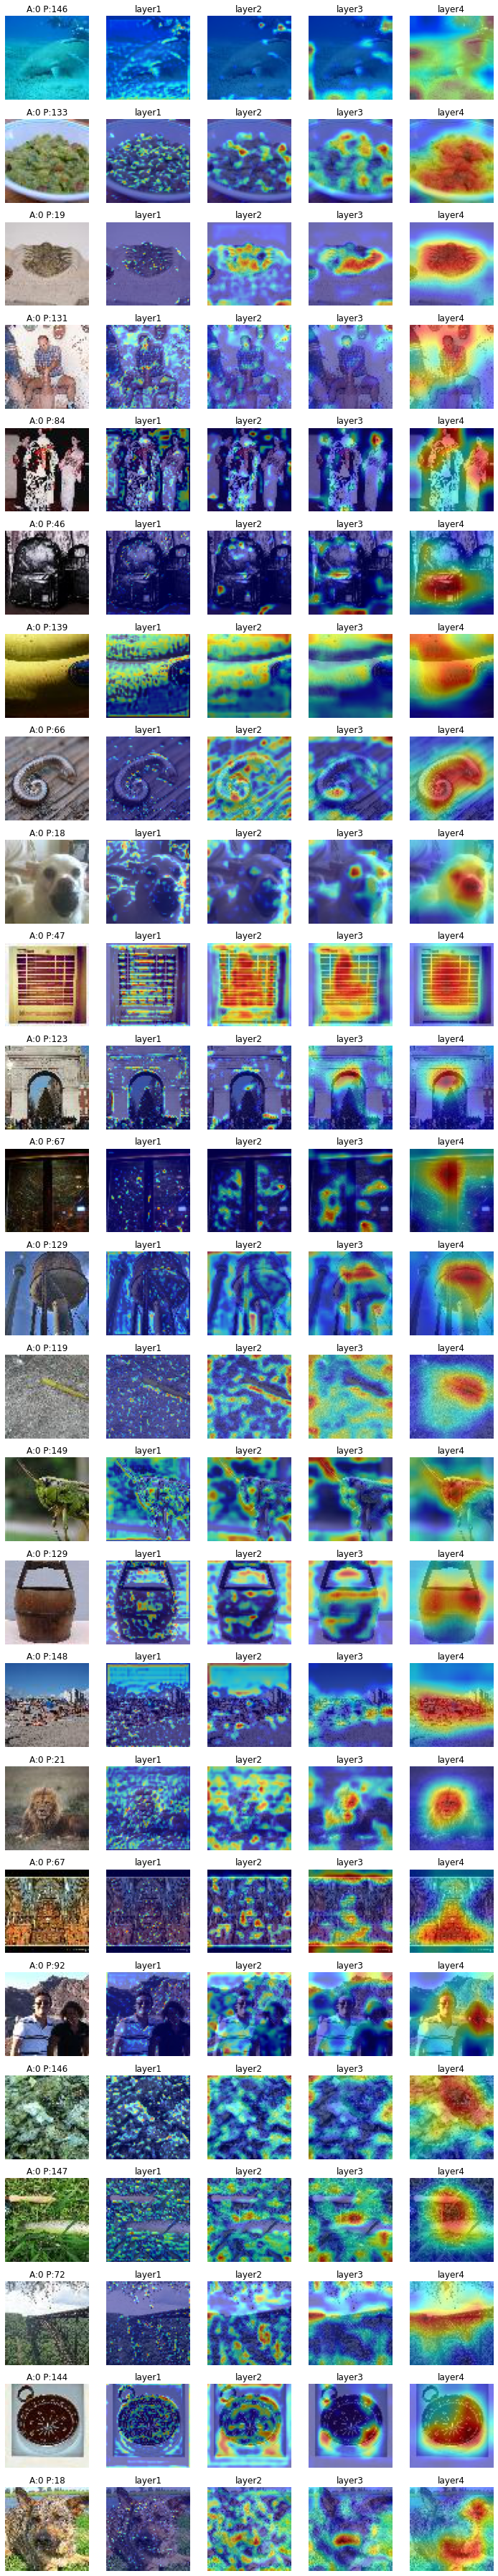

In [ ]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)